In [57]:
import pysindy as ps

import deepSI
from deepSI import System_data
from deepSI.fit_systems import SS_encoder_general
from deepSI.fit_systems.encoders import default_encoder_net, default_state_net, default_output_net
from deepSI.fit_systems.fit_system import My_Simple_DataLoader, print_array_byte_size, Tictoctimer
import torch
from torch import nn

import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from scipy.io import loadmat
import scipy.linalg as lin
import os

from utils import load_data
from data_processing import add_gaussian_noise

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import time
from copy import deepcopy
import itertools

import re

from feature_construction import feature_library
import polynomial as p
import fourier as f

import SI_SUBNET
from SI_SUBNET import SS_encoder_general_eq, h_identity, e_identity, simple_Linear
from SI_metrics import plot_coeff_grid, display_equation
from data_processing import plot_fft

import nonlinear_benchmarks

from scipy.signal import savgol_filter

*****LOAD DATA*****

In [58]:
# full sb
# x_full = loadmat(r"C:\Users\Joost\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data\Silverbox_full_state_low_error.mat")["xOptTot"]
# u_full = loadmat(r"C:\Users\Joost\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data\Silverbox_u_upsampled.mat")['u'].flatten()

# less upsampled
data = loadmat(r"C:\Users\Joost\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data\upsampled_silverbox.mat")
x_full = data["sb_y_data"][:,:2]
u_full = data["sb_y_data"][:,2].flatten()

N_arrow = round(40475/131072*x_full.shape[0])
N_extar = round(32000/131072*x_full.shape[0])
N_train = round(65062/131072*x_full.shape[0])
N_multi = round(21688/131072*x_full.shape[0])
N_tot = N_arrow+N_extar+N_train+N_multi

In [59]:
train_val_x, train_val_u = x_full[N_arrow:N_arrow+N_train,:], u_full[N_arrow:N_arrow+N_train]
test_mul_x,  test_mul_u  = x_full[N_arrow+N_train:N_tot,:], u_full[N_arrow+N_train:N_tot]
test_arr_x,  test_arr_u  = x_full[:N_arrow,:], u_full[:N_arrow]
test_nx_arr_x,  test_nx_arr_u  = test_arr_x[:N_extar,:],  test_arr_u[:N_extar]

train = System_data(u=train_val_u[:], y=train_val_x[:,:])
val = System_data(u=train_val_u[-500:], y=train_val_x[-500:,:])
test_arrow_full = System_data(u=test_arr_u, y=test_arr_x)
test_multisine = System_data(u=test_mul_u, y=test_mul_x)
arrow_next = System_data(u=test_nx_arr_u, y=test_nx_arr_x)

train_val_x.shape, test_mul_x.shape, test_arr_x.shape, test_nx_arr_x.shape

((1301240, 2), (510700, 2), (809500, 2), (640000, 2))

In [60]:
train.y.shape, train.u.shape, val.y.shape, val.u.shape

((1301240, 2), (1301240,), (500, 2), (500,))

In [61]:
T = np.diag(2/np.ptp(test_arrow_full.y, axis=0))

U = 1/np.ptp(test_arrow_full.u)*np.eye(1)

In [62]:
train_set = np.c_[T[0,0]*train.y[:,0], T[1,1]*train.y[:,1]]
val_set   = np.c_[T[0,0]*val.y[:,0], T[1,1]*val.y[:,1]]
taf_set   = np.c_[T[0,0]*test_arrow_full.y[:,0], T[1,1]*test_arrow_full.y[:,1]]
tm_set    = np.c_[T[0,0]*test_multisine.y[:,0], T[1,1]*test_multisine.y[:,1]]
tae_set   = np.c_[T[0,0]*arrow_next.y[:,0], T[1,1]*arrow_next.y[:,1]]

In [63]:
train           = System_data(u=U[0]*train.u, y=train_set)
val             = System_data(u=U[0]*val.u, y=val_set)
test_arrow_full = System_data(u=U[0]*test_arrow_full.u, y=taf_set)
test_multisine  = System_data(u=U[0]*test_multisine.u, y=tm_set)
test_arrow_no_extrapolation = System_data(u=U[0]*arrow_next.u, y=tae_set)

In [64]:
train.y.shape, train.u.shape, val.y.shape, val.u.shape

((1301240, 2), (1301240,), (500, 2), (500,))

*****SPECIFY FUNCTIONS TO BE CONSIDERED*****

In [65]:
functions = [p.f, p.f2, p.f3]# p.f6, p.f7, p.f8, p.f9, p.f10, p.f11, p.f12, p.f13, p.f14, p.f15, p.f16, p.f17, p.f18, p.f19, p.f20], f.sin, f.cos, f.sin2x, f.cos2x, f.sin3x, f.cos3x
# functions = [p.f, f.sin, f.cos, f.sin2x, f.cos2x, f.sin3x, f.cos3x, f.sin4x, f.cos4x, f.sin5x, f.cos5x, f.sin6x, f.cos6x, f.sin7x, f.cos7x, f.sin8x, f.cos8x, f.sin9x, f.cos9x, f.sin10x, f.cos10x]#,\
            #   f.sin11x, f.cos11x, f.sin12x, f.cos12x, f.sin13x, f.cos13x, f.sin14x, f.cos14x, f.sin15x, f.cos15x, f.sin16x, f.cos16x, f.sin17x, f.cos17x, f.sin18x, f.cos18x, f.sin19x, f.cos19x, f.sin20x, f.cos20x]
# functions = [p.f, p.f3]
poly = feature_library(functions=functions, nx=2, nu=1, T=T, U=U)#, exclude_idx=[0,5,6,8,9]

In [66]:
poly.feature_names

['1',
 'x0[k]',
 'x1[k]',
 'u0[k]',
 'x0[k]**2',
 'x1[k]**2',
 'u0[k]**2',
 'x0[k]**3',
 'x1[k]**3',
 'u0[k]**3']

*****INITIALIZE NETWORK*****

In [67]:
batch_size = 256

# network param
nx, nu = 2, 1 # state dimension and inputs
na, nb = 0, 0
na_right = 1

f_net_kwargs = {"feature_library": poly, "u": nu, "nf": poly.feature_number()}

# output model
h_net = h_identity
h_net_kwargs = {}

# encoder model
e_net = e_identity
e_net_kwargs = {}

# SI-SUBNET initialization
fit_sys = SS_encoder_general_eq(nx=nx, na=na, nb=nb, na_right=na_right,\
                                    f_net_kwargs=f_net_kwargs,\
                                    e_net=e_net, e_net_kwargs=e_net_kwargs,\
                                    h_net=h_net, h_net_kwargs=h_net_kwargs)

*****PRETRAIN 1STEP AHEAD*****

In [68]:
nf = 1
batch_size = 1024

# regularization
gamma = 1e-3
mode = None
T_idx = None

# pruning
pruning = True
epo_idx = 15
threshold = 5*10**-5
pruning_mode = "RMS"

loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx, pruning_mode=pruning_mode)

fit_sys.fit(train, val, epochs=151, batch_size = batch_size, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

Initilizing the model and optimizer
Size of the training array =  79.4 MB
N_training_samples = 1301239, batch_size = 1024, N_batch_updates_per_epoch = 1270
Initial Validation sim-NRMS= 1.2951554512217363


  1%|          | 1/151 [00:02<05:54,  2.36s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.9959399404603191
Epoch    1, sqrt loss  0.1009, Val sim-NRMS 0.9959, Time Loss: 79.9%, data: 13.1%, val: 5.7%, 537.1 batches/sec


  1%|▏         | 2/151 [00:04<05:54,  2.38s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.9635523872797876
Epoch    2, sqrt loss 0.06612, Val sim-NRMS 0.9636, Time Loss: 78.9%, data: 14.2%, val: 5.7%, 534.2 batches/sec


  2%|▏         | 3/151 [00:07<06:02,  2.45s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.9376208216044293
Epoch    3, sqrt loss  0.0621, Val sim-NRMS 0.9376, Time Loss: 78.1%, data: 14.5%, val: 6.2%, 522.5 batches/sec


  3%|▎         | 4/151 [00:09<05:59,  2.45s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.8720407140028676
Epoch    4, sqrt loss 0.05723, Val sim-NRMS  0.872, Time Loss: 78.4%, data: 14.2%, val: 6.3%, 522.0 batches/sec


  3%|▎         | 5/151 [00:12<05:58,  2.45s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.6105549932175649
Epoch    5, sqrt loss 0.05209, Val sim-NRMS 0.6106, Time Loss: 78.5%, data: 13.9%, val: 6.4%, 520.7 batches/sec


  4%|▍         | 6/151 [00:14<05:56,  2.46s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.10312069759779494
Epoch    6, sqrt loss  0.0481, Val sim-NRMS 0.1031, Time Loss: 78.4%, data: 13.7%, val: 6.7%, 519.9 batches/sec


  5%|▍         | 7/151 [00:17<05:58,  2.49s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.014217664692580116
Epoch    7, sqrt loss 0.04636, Val sim-NRMS 0.01422, Time Loss: 78.3%, data: 13.7%, val: 6.8%, 516.1 batches/sec


  5%|▌         | 8/151 [00:19<05:51,  2.46s/it]

Epoch    8, sqrt loss 0.04601, Val sim-NRMS 0.01909, Time Loss: 78.5%, data: 13.7%, val: 6.6%, 518.3 batches/sec


  6%|▌         | 9/151 [00:22<05:53,  2.49s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.011504954643953184
Epoch    9, sqrt loss 0.04598, Val sim-NRMS 0.0115, Time Loss: 78.3%, data: 13.6%, val: 6.9%, 515.7 batches/sec


  7%|▋         | 10/151 [00:24<05:52,  2.50s/it]

Epoch   10, sqrt loss 0.04598, Val sim-NRMS 0.01154, Time Loss: 78.5%, data: 13.7%, val: 6.7%, 514.4 batches/sec


  7%|▋         | 11/151 [00:27<05:50,  2.50s/it]

Epoch   11, sqrt loss 0.04598, Val sim-NRMS 0.01466, Time Loss: 78.6%, data: 13.7%, val: 6.5%, 513.7 batches/sec


  8%|▊         | 12/151 [00:29<05:45,  2.48s/it]

Epoch   12, sqrt loss 0.04599, Val sim-NRMS 0.02521, Time Loss: 78.7%, data: 13.8%, val: 6.4%, 514.3 batches/sec


  9%|▊         | 13/151 [00:32<05:47,  2.51s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.009717711216354296
Epoch   13, sqrt loss 0.04599, Val sim-NRMS 0.009718, Time Loss: 78.5%, data: 13.7%, val: 6.7%, 512.4 batches/sec


  9%|▉         | 14/151 [00:34<05:41,  2.49s/it]

Epoch   14, sqrt loss 0.04599, Val sim-NRMS 0.01275, Time Loss: 78.6%, data: 13.7%, val: 6.5%, 512.8 batches/sec


 10%|▉         | 15/151 [00:37<05:36,  2.48s/it]

Epoch   15, sqrt loss 0.04598, Val sim-NRMS 0.01227, Time Loss: 78.7%, data: 13.7%, val: 6.4%, 513.3 batches/sec


 11%|█         | 16/151 [00:39<05:37,  2.50s/it]

tensor([[ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])
Epoch   16, sqrt loss 0.04599, Val sim-NRMS  0.022, Time Loss: 78.6%, data: 13.7%, val: 6.3%, 512.2 batches/sec


 11%|█▏        | 17/151 [00:42<05:37,  2.52s/it]

Epoch   17, sqrt loss 0.04599, Val sim-NRMS 0.01054, Time Loss: 78.8%, data: 13.6%, val: 6.3%, 511.3 batches/sec


 12%|█▏        | 18/151 [00:44<05:37,  2.54s/it]

Epoch   18, sqrt loss 0.04598, Val sim-NRMS 0.01652, Time Loss: 78.9%, data: 13.6%, val: 6.2%, 510.3 batches/sec


 13%|█▎        | 19/151 [00:47<05:33,  2.53s/it]

Epoch   19, sqrt loss 0.04599, Val sim-NRMS 0.01307, Time Loss: 78.9%, data: 13.6%, val: 6.1%, 510.0 batches/sec


 13%|█▎        | 20/151 [00:49<05:32,  2.54s/it]

Epoch   20, sqrt loss 0.04598, Val sim-NRMS 0.01774, Time Loss: 79.0%, data: 13.6%, val: 6.1%, 509.3 batches/sec


 14%|█▍        | 21/151 [00:52<05:32,  2.56s/it]

Epoch   21, sqrt loss 0.04599, Val sim-NRMS 0.02657, Time Loss: 79.0%, data: 13.6%, val: 6.0%, 508.2 batches/sec


 15%|█▍        | 22/151 [00:55<05:35,  2.60s/it]

Epoch   22, sqrt loss 0.04599, Val sim-NRMS 0.03846, Time Loss: 79.1%, data: 13.6%, val: 5.9%, 506.5 batches/sec


 15%|█▌        | 23/151 [00:57<05:32,  2.60s/it]

Epoch   23, sqrt loss 0.04599, Val sim-NRMS 0.01282, Time Loss: 79.2%, data: 13.6%, val: 5.9%, 505.7 batches/sec


 16%|█▌        | 24/151 [01:00<05:29,  2.60s/it]

Epoch   24, sqrt loss 0.04599, Val sim-NRMS 0.01066, Time Loss: 79.2%, data: 13.6%, val: 5.9%, 504.9 batches/sec


 17%|█▋        | 25/151 [01:02<05:24,  2.58s/it]

Epoch   25, sqrt loss 0.04599, Val sim-NRMS 0.01038, Time Loss: 79.3%, data: 13.6%, val: 5.8%, 504.9 batches/sec


 17%|█▋        | 26/151 [01:05<05:17,  2.54s/it]

Epoch   26, sqrt loss 0.04599, Val sim-NRMS 0.02247, Time Loss: 79.4%, data: 13.5%, val: 5.8%, 505.3 batches/sec


 18%|█▊        | 27/151 [01:07<05:13,  2.53s/it]

Epoch   27, sqrt loss 0.04599, Val sim-NRMS 0.02727, Time Loss: 79.4%, data: 13.5%, val: 5.8%, 505.3 batches/sec


 19%|█▊        | 28/151 [01:10<05:21,  2.62s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.009242018483226528
Epoch   28, sqrt loss 0.04599, Val sim-NRMS 0.009242, Time Loss: 79.1%, data: 13.5%, val: 6.2%, 503.2 batches/sec


 19%|█▉        | 29/151 [01:13<05:15,  2.59s/it]

Epoch   29, sqrt loss 0.04598, Val sim-NRMS 0.01195, Time Loss: 79.2%, data: 13.5%, val: 6.1%, 503.2 batches/sec


 20%|█▉        | 30/151 [01:15<05:14,  2.60s/it]

Epoch   30, sqrt loss 0.04599, Val sim-NRMS 0.009927, Time Loss: 79.2%, data: 13.5%, val: 6.1%, 502.6 batches/sec


 21%|██        | 31/151 [01:18<05:17,  2.65s/it]

tensor([[ True,  True,  True,  True,  True, False,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])
Epoch   31, sqrt loss 0.04599, Val sim-NRMS 0.01987, Time Loss: 79.1%, data: 13.5%, val: 6.0%, 501.0 batches/sec


 21%|██        | 32/151 [01:21<05:16,  2.66s/it]

Epoch   32, sqrt loss 0.04598, Val sim-NRMS 0.02286, Time Loss: 79.2%, data: 13.4%, val: 6.0%, 500.1 batches/sec


 22%|██▏       | 33/151 [01:24<05:19,  2.71s/it]

Epoch   33, sqrt loss 0.04598, Val sim-NRMS 0.01883, Time Loss: 79.1%, data: 13.5%, val: 6.0%, 498.5 batches/sec


 23%|██▎       | 34/151 [01:26<05:19,  2.73s/it]

Epoch   34, sqrt loss 0.04598, Val sim-NRMS 0.01851, Time Loss: 79.2%, data: 13.5%, val: 5.9%, 497.2 batches/sec


 23%|██▎       | 35/151 [01:29<05:11,  2.68s/it]

Epoch   35, sqrt loss 0.04599, Val sim-NRMS 0.02599, Time Loss: 79.2%, data: 13.5%, val: 5.9%, 497.0 batches/sec


 24%|██▍       | 36/151 [01:31<05:01,  2.62s/it]

Epoch   36, sqrt loss 0.04598, Val sim-NRMS 0.02289, Time Loss: 79.2%, data: 13.5%, val: 5.9%, 497.4 batches/sec


 25%|██▍       | 37/151 [01:34<04:54,  2.59s/it]

Epoch   37, sqrt loss 0.04598, Val sim-NRMS 0.01512, Time Loss: 79.3%, data: 13.5%, val: 5.9%, 497.7 batches/sec


 25%|██▌       | 38/151 [01:36<04:50,  2.57s/it]

Epoch   38, sqrt loss 0.04598, Val sim-NRMS 0.01044, Time Loss: 79.3%, data: 13.4%, val: 5.8%, 497.7 batches/sec


 26%|██▌       | 39/151 [01:39<04:49,  2.58s/it]

Epoch   39, sqrt loss 0.04598, Val sim-NRMS 0.02207, Time Loss: 79.4%, data: 13.4%, val: 5.8%, 497.5 batches/sec


 26%|██▋       | 40/151 [01:42<04:45,  2.57s/it]

Epoch   40, sqrt loss 0.04598, Val sim-NRMS 0.01812, Time Loss: 79.4%, data: 13.4%, val: 5.8%, 497.5 batches/sec


 27%|██▋       | 41/151 [01:44<04:41,  2.56s/it]

Epoch   41, sqrt loss 0.04598, Val sim-NRMS 0.02314, Time Loss: 79.4%, data: 13.4%, val: 5.8%, 497.6 batches/sec


 28%|██▊       | 42/151 [01:47<04:49,  2.65s/it]

Epoch   42, sqrt loss 0.04598, Val sim-NRMS 0.01973, Time Loss: 79.4%, data: 13.5%, val: 5.8%, 496.1 batches/sec


 28%|██▊       | 43/151 [01:50<04:51,  2.70s/it]

Epoch   43, sqrt loss 0.04598, Val sim-NRMS 0.01572, Time Loss: 79.3%, data: 13.5%, val: 5.8%, 495.0 batches/sec


 29%|██▉       | 44/151 [01:53<04:49,  2.70s/it]

Epoch   44, sqrt loss 0.04598, Val sim-NRMS 0.0122, Time Loss: 79.3%, data: 13.5%, val: 5.8%, 494.3 batches/sec


 30%|██▉       | 45/151 [01:55<04:41,  2.66s/it]

Epoch   45, sqrt loss 0.04598, Val sim-NRMS 0.01123, Time Loss: 79.4%, data: 13.6%, val: 5.7%, 494.4 batches/sec


 30%|███       | 46/151 [01:58<04:41,  2.69s/it]

tensor([[ True,  True,  True,  True,  True, False, False,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])
Epoch   46, sqrt loss 0.04598, Val sim-NRMS  0.028, Time Loss: 79.2%, data: 13.6%, val: 5.7%, 493.7 batches/sec


 31%|███       | 47/151 [02:00<04:32,  2.62s/it]

Epoch   47, sqrt loss 0.04598, Val sim-NRMS 0.02207, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 494.1 batches/sec


 32%|███▏      | 48/151 [02:03<04:27,  2.59s/it]

Epoch   48, sqrt loss 0.04598, Val sim-NRMS 0.01779, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 494.3 batches/sec


 32%|███▏      | 49/151 [02:05<04:21,  2.56s/it]

Epoch   49, sqrt loss 0.04598, Val sim-NRMS 0.0131, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 494.6 batches/sec


 33%|███▎      | 50/151 [02:08<04:14,  2.52s/it]

Epoch   50, sqrt loss 0.04598, Val sim-NRMS 0.01476, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 495.2 batches/sec


 34%|███▍      | 51/151 [02:10<04:12,  2.53s/it]

Epoch   51, sqrt loss 0.04598, Val sim-NRMS 0.01786, Time Loss: 79.4%, data: 13.5%, val: 5.7%, 495.2 batches/sec


 34%|███▍      | 52/151 [02:13<04:15,  2.58s/it]

Epoch   52, sqrt loss 0.04598, Val sim-NRMS 0.01812, Time Loss: 79.4%, data: 13.5%, val: 5.6%, 494.7 batches/sec


 35%|███▌      | 53/151 [02:16<04:11,  2.57s/it]

Epoch   53, sqrt loss 0.04599, Val sim-NRMS 0.0218, Time Loss: 79.4%, data: 13.5%, val: 5.6%, 494.8 batches/sec


 36%|███▌      | 54/151 [02:18<04:10,  2.58s/it]

Epoch   54, sqrt loss 0.04599, Val sim-NRMS 0.01465, Time Loss: 79.4%, data: 13.5%, val: 5.6%, 494.7 batches/sec


 36%|███▋      | 55/151 [02:21<04:09,  2.60s/it]

Epoch   55, sqrt loss 0.04598, Val sim-NRMS 0.01796, Time Loss: 79.4%, data: 13.5%, val: 5.6%, 494.3 batches/sec


 37%|███▋      | 56/151 [02:24<04:27,  2.81s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.008567215434364669
Epoch   56, sqrt loss 0.04598, Val sim-NRMS 0.008567, Time Loss: 79.0%, data: 13.5%, val: 6.0%, 491.8 batches/sec


 38%|███▊      | 57/151 [02:27<04:15,  2.72s/it]

Epoch   57, sqrt loss 0.04598, Val sim-NRMS 0.01376, Time Loss: 79.1%, data: 13.5%, val: 6.0%, 492.1 batches/sec


 38%|███▊      | 58/151 [02:29<04:07,  2.66s/it]

Epoch   58, sqrt loss 0.04598, Val sim-NRMS 0.03105, Time Loss: 79.1%, data: 13.5%, val: 6.0%, 492.3 batches/sec


 39%|███▉      | 59/151 [02:32<04:03,  2.64s/it]

Epoch   59, sqrt loss 0.04598, Val sim-NRMS 0.0218, Time Loss: 79.1%, data: 13.5%, val: 6.0%, 492.2 batches/sec


 40%|███▉      | 60/151 [02:34<03:59,  2.63s/it]

Epoch   60, sqrt loss 0.04598, Val sim-NRMS 0.02299, Time Loss: 79.1%, data: 13.5%, val: 6.0%, 492.2 batches/sec


 40%|████      | 61/151 [02:37<04:03,  2.71s/it]

tensor([[ True,  True,  True,  True, False, False, False,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])
Epoch   61, sqrt loss 0.04598, Val sim-NRMS 0.01998, Time Loss: 79.0%, data: 13.5%, val: 5.9%, 491.2 batches/sec


 41%|████      | 62/151 [02:40<03:57,  2.67s/it]

Epoch   62, sqrt loss 0.04598, Val sim-NRMS 0.009992, Time Loss: 79.0%, data: 13.5%, val: 5.9%, 491.2 batches/sec


 42%|████▏     | 63/151 [02:42<03:52,  2.64s/it]

Epoch   63, sqrt loss 0.04598, Val sim-NRMS 0.01023, Time Loss: 79.1%, data: 13.5%, val: 5.9%, 491.2 batches/sec


 42%|████▏     | 64/151 [02:45<03:49,  2.64s/it]

Epoch   64, sqrt loss 0.04598, Val sim-NRMS 0.009954, Time Loss: 79.1%, data: 13.5%, val: 5.9%, 491.0 batches/sec


 43%|████▎     | 65/151 [02:48<03:47,  2.64s/it]

Epoch   65, sqrt loss 0.04598, Val sim-NRMS 0.01029, Time Loss: 79.1%, data: 13.5%, val: 5.9%, 490.9 batches/sec


 44%|████▎     | 66/151 [02:50<03:47,  2.67s/it]

Epoch   66, sqrt loss 0.04598, Val sim-NRMS 0.01115, Time Loss: 79.1%, data: 13.5%, val: 5.9%, 490.4 batches/sec


 44%|████▍     | 67/151 [02:53<03:44,  2.68s/it]

Epoch   67, sqrt loss 0.04598, Val sim-NRMS 0.02087, Time Loss: 79.1%, data: 13.5%, val: 5.8%, 490.1 batches/sec


 45%|████▌     | 68/151 [02:56<03:40,  2.66s/it]

Epoch   68, sqrt loss 0.04598, Val sim-NRMS 0.01358, Time Loss: 79.2%, data: 13.5%, val: 5.8%, 490.1 batches/sec


 46%|████▌     | 69/151 [02:58<03:38,  2.66s/it]

Epoch   69, sqrt loss 0.04598, Val sim-NRMS 0.01748, Time Loss: 79.2%, data: 13.5%, val: 5.8%, 489.9 batches/sec


 46%|████▋     | 70/151 [03:01<03:32,  2.63s/it]

Epoch   70, sqrt loss 0.04598, Val sim-NRMS 0.009132, Time Loss: 79.2%, data: 13.5%, val: 5.8%, 490.0 batches/sec


 47%|████▋     | 71/151 [03:04<03:29,  2.62s/it]

Epoch   71, sqrt loss 0.04598, Val sim-NRMS 0.01381, Time Loss: 79.2%, data: 13.5%, val: 5.8%, 489.9 batches/sec


 48%|████▊     | 72/151 [03:06<03:27,  2.62s/it]

Epoch   72, sqrt loss 0.04598, Val sim-NRMS 0.01613, Time Loss: 79.2%, data: 13.5%, val: 5.8%, 489.9 batches/sec


 48%|████▊     | 73/151 [03:09<03:25,  2.64s/it]

Epoch   73, sqrt loss 0.04598, Val sim-NRMS 0.01796, Time Loss: 79.3%, data: 13.5%, val: 5.8%, 489.6 batches/sec


 49%|████▉     | 74/151 [03:11<03:22,  2.64s/it]

Epoch   74, sqrt loss 0.04598, Val sim-NRMS 0.01523, Time Loss: 79.3%, data: 13.5%, val: 5.8%, 489.6 batches/sec


 50%|████▉     | 75/151 [03:14<03:23,  2.67s/it]

Epoch   75, sqrt loss 0.04598, Val sim-NRMS 0.01789, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 489.2 batches/sec


 50%|█████     | 76/151 [03:17<03:27,  2.76s/it]

tensor([[ True,  True,  True,  True, False, False, False,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False]])
Epoch   76, sqrt loss 0.04598, Val sim-NRMS 0.01302, Time Loss: 79.2%, data: 13.5%, val: 5.7%, 488.2 batches/sec


 51%|█████     | 77/151 [03:20<03:24,  2.77s/it]

Epoch   77, sqrt loss 0.04598, Val sim-NRMS 0.02345, Time Loss: 79.2%, data: 13.5%, val: 5.7%, 487.8 batches/sec


 52%|█████▏    | 78/151 [03:22<03:16,  2.69s/it]

Epoch   78, sqrt loss 0.04598, Val sim-NRMS 0.02274, Time Loss: 79.2%, data: 13.5%, val: 5.7%, 488.0 batches/sec


 52%|█████▏    | 79/151 [03:25<03:10,  2.64s/it]

Epoch   79, sqrt loss 0.04598, Val sim-NRMS 0.01564, Time Loss: 79.2%, data: 13.5%, val: 5.7%, 488.2 batches/sec


 53%|█████▎    | 80/151 [03:27<03:03,  2.59s/it]

Epoch   80, sqrt loss 0.04598, Val sim-NRMS 0.02322, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 488.5 batches/sec


 54%|█████▎    | 81/151 [03:30<02:59,  2.56s/it]

Epoch   81, sqrt loss 0.04598, Val sim-NRMS 0.02291, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 488.8 batches/sec


 54%|█████▍    | 82/151 [03:32<02:55,  2.55s/it]

Epoch   82, sqrt loss 0.04598, Val sim-NRMS 0.01189, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 488.9 batches/sec


 55%|█████▍    | 83/151 [03:35<02:54,  2.57s/it]

Epoch   83, sqrt loss 0.04598, Val sim-NRMS 0.01112, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 488.9 batches/sec


 56%|█████▌    | 84/151 [03:38<02:50,  2.55s/it]

Epoch   84, sqrt loss 0.04598, Val sim-NRMS 0.01637, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 489.1 batches/sec


 56%|█████▋    | 85/151 [03:40<02:47,  2.53s/it]

Epoch   85, sqrt loss 0.04598, Val sim-NRMS 0.01447, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 489.3 batches/sec


 57%|█████▋    | 86/151 [03:43<02:44,  2.53s/it]

Epoch   86, sqrt loss 0.04598, Val sim-NRMS 0.0135, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 489.5 batches/sec


 58%|█████▊    | 87/151 [03:45<02:40,  2.51s/it]

Epoch   87, sqrt loss 0.04598, Val sim-NRMS 0.02359, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 489.8 batches/sec


 58%|█████▊    | 88/151 [03:48<02:38,  2.52s/it]

Epoch   88, sqrt loss 0.04598, Val sim-NRMS 0.01068, Time Loss: 79.3%, data: 13.5%, val: 5.7%, 489.9 batches/sec


 59%|█████▉    | 89/151 [03:50<02:35,  2.51s/it]

Epoch   89, sqrt loss 0.04598, Val sim-NRMS 0.01877, Time Loss: 79.4%, data: 13.5%, val: 5.6%, 490.1 batches/sec


 60%|█████▉    | 90/151 [03:53<02:32,  2.50s/it]

Epoch   90, sqrt loss 0.04598, Val sim-NRMS 0.02146, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 490.3 batches/sec


 60%|██████    | 91/151 [03:55<02:36,  2.60s/it]

tensor([[ True,  True,  True,  True, False, False, False,  True,  True, False],
        [ True,  True,  True,  True,  True, False,  True,  True,  True, False]])
Epoch   91, sqrt loss 0.04598, Val sim-NRMS 0.01075, Time Loss: 79.3%, data: 13.4%, val: 5.6%, 489.8 batches/sec


 61%|██████    | 92/151 [03:58<02:32,  2.58s/it]

Epoch   92, sqrt loss 0.04598, Val sim-NRMS 0.03759, Time Loss: 79.3%, data: 13.4%, val: 5.6%, 489.9 batches/sec


 62%|██████▏   | 93/151 [04:00<02:27,  2.54s/it]

Epoch   93, sqrt loss 0.04598, Val sim-NRMS 0.009216, Time Loss: 79.3%, data: 13.4%, val: 5.6%, 490.2 batches/sec


 62%|██████▏   | 94/151 [04:03<02:24,  2.53s/it]

Epoch   94, sqrt loss 0.04598, Val sim-NRMS 0.01402, Time Loss: 79.3%, data: 13.4%, val: 5.6%, 490.4 batches/sec


 63%|██████▎   | 95/151 [04:05<02:21,  2.52s/it]

Epoch   95, sqrt loss 0.04598, Val sim-NRMS 0.02104, Time Loss: 79.3%, data: 13.4%, val: 5.6%, 490.6 batches/sec


 64%|██████▎   | 96/151 [04:08<02:18,  2.51s/it]

Epoch   96, sqrt loss 0.04598, Val sim-NRMS 0.01137, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 490.8 batches/sec


 64%|██████▍   | 97/151 [04:10<02:15,  2.50s/it]

Epoch   97, sqrt loss 0.04598, Val sim-NRMS 0.02174, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 491.0 batches/sec


 65%|██████▍   | 98/151 [04:13<02:12,  2.51s/it]

Epoch   98, sqrt loss 0.04598, Val sim-NRMS 0.02446, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 491.1 batches/sec


 66%|██████▌   | 99/151 [04:15<02:10,  2.50s/it]

Epoch   99, sqrt loss 0.04598, Val sim-NRMS 0.01789, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 491.3 batches/sec


 66%|██████▌   | 100/151 [04:18<02:09,  2.53s/it]

Epoch  100, sqrt loss 0.04598, Val sim-NRMS 0.01753, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 491.3 batches/sec


 67%|██████▋   | 101/151 [04:20<02:05,  2.52s/it]

Epoch  101, sqrt loss 0.04598, Val sim-NRMS 0.01471, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 491.5 batches/sec


 68%|██████▊   | 102/151 [04:23<02:02,  2.51s/it]

Epoch  102, sqrt loss 0.04598, Val sim-NRMS 0.01849, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 491.7 batches/sec


 68%|██████▊   | 103/151 [04:25<01:59,  2.50s/it]

Epoch  103, sqrt loss 0.04598, Val sim-NRMS 0.01878, Time Loss: 79.4%, data: 13.4%, val: 5.6%, 491.8 batches/sec


 69%|██████▉   | 104/151 [04:28<01:57,  2.50s/it]

Epoch  104, sqrt loss 0.04598, Val sim-NRMS 0.02999, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 492.0 batches/sec


 70%|██████▉   | 105/151 [04:30<01:54,  2.50s/it]

Epoch  105, sqrt loss 0.04598, Val sim-NRMS 0.01969, Time Loss: 79.5%, data: 13.4%, val: 5.5%, 492.2 batches/sec


 70%|███████   | 106/151 [04:33<01:58,  2.62s/it]

tensor([[ True,  True,  True,  True, False, False, False,  True, False, False],
        [ True,  True,  True,  True,  True, False,  True,  True,  True, False]])
Epoch  106, sqrt loss 0.04598, Val sim-NRMS 0.01656, Time Loss: 79.3%, data: 13.4%, val: 5.5%, 491.5 batches/sec


 71%|███████   | 107/151 [04:36<01:53,  2.58s/it]

Epoch  107, sqrt loss 0.04598, Val sim-NRMS 0.01259, Time Loss: 79.3%, data: 13.4%, val: 5.5%, 491.7 batches/sec


 72%|███████▏  | 108/151 [04:38<01:49,  2.55s/it]

Epoch  108, sqrt loss 0.04598, Val sim-NRMS 0.0297, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 491.9 batches/sec


 72%|███████▏  | 109/151 [04:41<01:46,  2.53s/it]

Epoch  109, sqrt loss 0.04598, Val sim-NRMS 0.02766, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 492.1 batches/sec


 73%|███████▎  | 110/151 [04:43<01:43,  2.52s/it]

Epoch  110, sqrt loss 0.04598, Val sim-NRMS 0.008657, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 492.2 batches/sec


 74%|███████▎  | 111/151 [04:46<01:40,  2.51s/it]

Epoch  111, sqrt loss 0.04598, Val sim-NRMS 0.02898, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 492.4 batches/sec


 74%|███████▍  | 112/151 [04:48<01:37,  2.51s/it]

Epoch  112, sqrt loss 0.04598, Val sim-NRMS 0.02446, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 492.5 batches/sec


 75%|███████▍  | 113/151 [04:51<01:35,  2.50s/it]

Epoch  113, sqrt loss 0.04598, Val sim-NRMS 0.01285, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 492.7 batches/sec


 75%|███████▌  | 114/151 [04:53<01:32,  2.49s/it]

Epoch  114, sqrt loss 0.04598, Val sim-NRMS 0.01976, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 492.9 batches/sec


 76%|███████▌  | 115/151 [04:56<01:29,  2.48s/it]

Epoch  115, sqrt loss 0.04598, Val sim-NRMS 0.02188, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 493.0 batches/sec


 77%|███████▋  | 116/151 [04:58<01:27,  2.49s/it]

Epoch  116, sqrt loss 0.04598, Val sim-NRMS 0.01647, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 493.2 batches/sec


 77%|███████▋  | 117/151 [05:01<01:24,  2.48s/it]

Epoch  117, sqrt loss 0.04598, Val sim-NRMS 0.01195, Time Loss: 79.5%, data: 13.4%, val: 5.5%, 493.3 batches/sec


 78%|███████▊  | 118/151 [05:03<01:21,  2.48s/it]

Epoch  118, sqrt loss 0.04598, Val sim-NRMS 0.02028, Time Loss: 79.5%, data: 13.4%, val: 5.5%, 493.5 batches/sec


 79%|███████▉  | 119/151 [05:06<01:19,  2.49s/it]

Epoch  119, sqrt loss 0.04598, Val sim-NRMS 0.01996, Time Loss: 79.5%, data: 13.4%, val: 5.5%, 493.6 batches/sec


 79%|███████▉  | 120/151 [05:08<01:17,  2.50s/it]

Epoch  120, sqrt loss 0.04598, Val sim-NRMS 0.02594, Time Loss: 79.5%, data: 13.4%, val: 5.5%, 493.7 batches/sec


 80%|████████  | 121/151 [05:11<01:18,  2.63s/it]

tensor([[ True,  True,  True,  True, False, False, False,  True, False, False],
        [ True,  True,  True,  True,  True, False, False,  True,  True, False]])
Epoch  121, sqrt loss 0.04598, Val sim-NRMS 0.02861, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 493.1 batches/sec


 81%|████████  | 122/151 [05:14<01:15,  2.60s/it]

Epoch  122, sqrt loss 0.04597, Val sim-NRMS 0.02785, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 493.2 batches/sec


 81%|████████▏ | 123/151 [05:16<01:12,  2.57s/it]

Epoch  123, sqrt loss 0.04597, Val sim-NRMS 0.01649, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 493.3 batches/sec


 82%|████████▏ | 124/151 [05:19<01:09,  2.56s/it]

Epoch  124, sqrt loss 0.04597, Val sim-NRMS  0.029, Time Loss: 79.4%, data: 13.4%, val: 5.5%, 493.3 batches/sec


 83%|████████▎ | 125/151 [05:21<01:06,  2.55s/it]

Epoch  125, sqrt loss 0.04597, Val sim-NRMS 0.0173, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.4 batches/sec


 83%|████████▎ | 126/151 [05:24<01:03,  2.53s/it]

Epoch  126, sqrt loss 0.04597, Val sim-NRMS 0.01351, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.6 batches/sec


 84%|████████▍ | 127/151 [05:26<01:00,  2.52s/it]

Epoch  127, sqrt loss 0.04597, Val sim-NRMS 0.02086, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.7 batches/sec


 85%|████████▍ | 128/151 [05:29<00:58,  2.53s/it]

Epoch  128, sqrt loss 0.04597, Val sim-NRMS 0.01359, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.7 batches/sec


 85%|████████▌ | 129/151 [05:31<00:55,  2.52s/it]

Epoch  129, sqrt loss 0.04597, Val sim-NRMS 0.01313, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.8 batches/sec


 86%|████████▌ | 130/151 [05:34<00:52,  2.52s/it]

Epoch  130, sqrt loss 0.04597, Val sim-NRMS 0.01455, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.9 batches/sec


 87%|████████▋ | 131/151 [05:36<00:50,  2.51s/it]

Epoch  131, sqrt loss 0.04597, Val sim-NRMS 0.02939, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.1 batches/sec


 87%|████████▋ | 132/151 [05:39<00:47,  2.51s/it]

Epoch  132, sqrt loss 0.04597, Val sim-NRMS 0.01112, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.1 batches/sec


 88%|████████▊ | 133/151 [05:41<00:45,  2.50s/it]

Epoch  133, sqrt loss 0.04597, Val sim-NRMS 0.01722, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.2 batches/sec


 89%|████████▊ | 134/151 [05:44<00:42,  2.50s/it]

Epoch  134, sqrt loss 0.04597, Val sim-NRMS 0.03123, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.4 batches/sec


 89%|████████▉ | 135/151 [05:46<00:40,  2.50s/it]

Epoch  135, sqrt loss 0.04597, Val sim-NRMS 0.02782, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.5 batches/sec


 90%|█████████ | 136/151 [05:49<00:40,  2.67s/it]

tensor([[ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False,  True,  True, False]])
Epoch  136, sqrt loss 0.04597, Val sim-NRMS 0.01982, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.8 batches/sec


 91%|█████████ | 137/151 [05:52<00:36,  2.62s/it]

Epoch  137, sqrt loss 0.04597, Val sim-NRMS 0.02089, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.8 batches/sec


 91%|█████████▏| 138/151 [05:54<00:33,  2.59s/it]

Epoch  138, sqrt loss 0.04597, Val sim-NRMS 0.01387, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 493.9 batches/sec


 92%|█████████▏| 139/151 [05:57<00:30,  2.56s/it]

Epoch  139, sqrt loss 0.04597, Val sim-NRMS 0.01613, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 494.0 batches/sec


 93%|█████████▎| 140/151 [05:59<00:27,  2.54s/it]

Epoch  140, sqrt loss 0.04597, Val sim-NRMS 0.01333, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 494.1 batches/sec


 93%|█████████▎| 141/151 [06:02<00:25,  2.54s/it]

Epoch  141, sqrt loss 0.04597, Val sim-NRMS 0.01243, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 494.2 batches/sec


 94%|█████████▍| 142/151 [06:04<00:22,  2.53s/it]

Epoch  142, sqrt loss 0.04597, Val sim-NRMS 0.02453, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 494.3 batches/sec


 95%|█████████▍| 143/151 [06:07<00:20,  2.52s/it]

Epoch  143, sqrt loss 0.04597, Val sim-NRMS 0.01075, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 494.4 batches/sec


 95%|█████████▌| 144/151 [06:09<00:17,  2.52s/it]

Epoch  144, sqrt loss 0.04597, Val sim-NRMS 0.01605, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 494.4 batches/sec


 96%|█████████▌| 145/151 [06:12<00:15,  2.52s/it]

Epoch  145, sqrt loss 0.04597, Val sim-NRMS 0.02936, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 494.5 batches/sec


 97%|█████████▋| 146/151 [06:14<00:12,  2.53s/it]

Epoch  146, sqrt loss 0.04597, Val sim-NRMS 0.01174, Time Loss: 79.4%, data: 13.4%, val: 5.4%, 494.5 batches/sec


 97%|█████████▋| 147/151 [06:17<00:10,  2.53s/it]

Epoch  147, sqrt loss 0.04597, Val sim-NRMS 0.02469, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.6 batches/sec


 98%|█████████▊| 148/151 [06:20<00:07,  2.54s/it]

Epoch  148, sqrt loss 0.04597, Val sim-NRMS 0.01077, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.6 batches/sec


 99%|█████████▊| 149/151 [06:22<00:05,  2.53s/it]

Epoch  149, sqrt loss 0.04597, Val sim-NRMS 0.01639, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.7 batches/sec


 99%|█████████▉| 150/151 [06:25<00:02,  2.52s/it]

Epoch  150, sqrt loss 0.04597, Val sim-NRMS 0.03086, Time Loss: 79.5%, data: 13.4%, val: 5.4%, 494.8 batches/sec


100%|██████████| 151/151 [06:28<00:00,  2.57s/it]

tensor([[ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False,  True,  True, False]])
Epoch  151, sqrt loss 0.04597, Val sim-NRMS 0.01876, Time Loss: 79.4%, data: 13.3%, val: 5.4%, 494.2 batches/sec


In [85]:
# pruning
pruning = False
# epo_idx = 3
# threshold = 5*10**-5
# pruning_mode = "RMS"

# nf = 100
# loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx, pruning_mode=pruning_mode)
# fit_sys.fit(train, val, epochs=10, batch_size = 8*batch_size, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

# pruning = False

nf = 200
loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx, pruning_mode=pruning_mode)
fit_sys.fit(train, val, epochs=10, batch_size = 8*batch_size, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  5.9 GB!
Consider using online_construct=True (in loss_kwargs) or let make_training_data return a Dataset to reduce data-usage
N_training_samples = 1301040, batch_size = 8192, N_batch_updates_per_epoch = 158
Initial Validation sim-NRMS= 0.007628897798127341


 10%|█         | 1/10 [01:23<12:32, 83.56s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.007026366095804501
Epoch    1, sqrt loss 0.04599, Val sim-NRMS 0.007026, Time Loss: 96.4%, data: 1.1%, val: 2.5%,  1.9 batches/sec


 20%|██        | 2/10 [02:44<10:56, 82.01s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.006980581927711088
Epoch    2, sqrt loss 0.04599, Val sim-NRMS 0.006981, Time Loss: 96.7%, data: 0.9%, val: 2.4%,  1.9 batches/sec


 30%|███       | 3/10 [04:04<09:28, 81.17s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.0066002693985389455
Epoch    3, sqrt loss 0.04599, Val sim-NRMS 0.0066, Time Loss: 96.9%, data: 0.8%, val: 2.3%,  1.9 batches/sec


 40%|████      | 4/10 [05:23<08:01, 80.29s/it]

Epoch    4, sqrt loss 0.04599, Val sim-NRMS 0.01142, Time Loss: 97.4%, data: 0.7%, val: 1.8%,  2.0 batches/sec


 50%|█████     | 5/10 [06:49<06:50, 82.13s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.006485299917292157
Epoch    5, sqrt loss 0.04599, Val sim-NRMS 0.006485, Time Loss: 97.4%, data: 0.7%, val: 1.9%,  1.9 batches/sec


 60%|██████    | 6/10 [08:10<05:27, 81.82s/it]

Epoch    6, sqrt loss 0.04599, Val sim-NRMS 0.007167, Time Loss: 97.7%, data: 0.7%, val: 1.6%,  1.9 batches/sec


 70%|███████   | 7/10 [09:33<04:06, 82.23s/it]

Epoch    7, sqrt loss 0.04599, Val sim-NRMS 0.007453, Time Loss: 97.9%, data: 0.7%, val: 1.4%,  1.9 batches/sec


 80%|████████  | 8/10 [11:12<02:55, 87.73s/it]

Epoch    8, sqrt loss 0.04599, Val sim-NRMS 0.008108, Time Loss: 98.1%, data: 0.7%, val: 1.2%,  1.9 batches/sec


 90%|█████████ | 9/10 [12:51<01:31, 91.15s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.006186921569965805
Epoch    9, sqrt loss 0.04599, Val sim-NRMS 0.006187, Time Loss: 98.0%, data: 0.7%, val: 1.3%,  1.8 batches/sec


100%|██████████| 10/10 [14:34<00:00, 87.46s/it]

Epoch   10, sqrt loss 0.04599, Val sim-NRMS 0.007053, Time Loss: 98.2%, data: 0.6%, val: 1.2%,  1.8 batches/sec


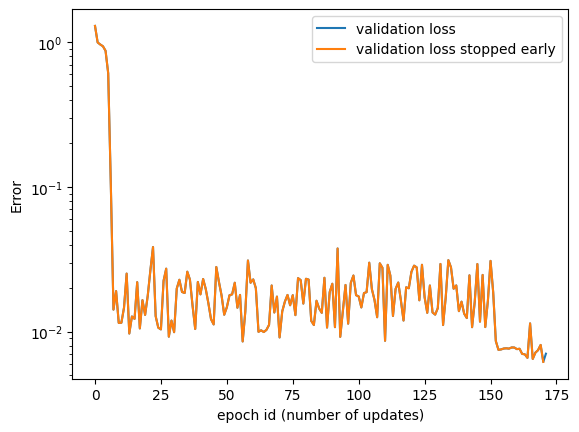

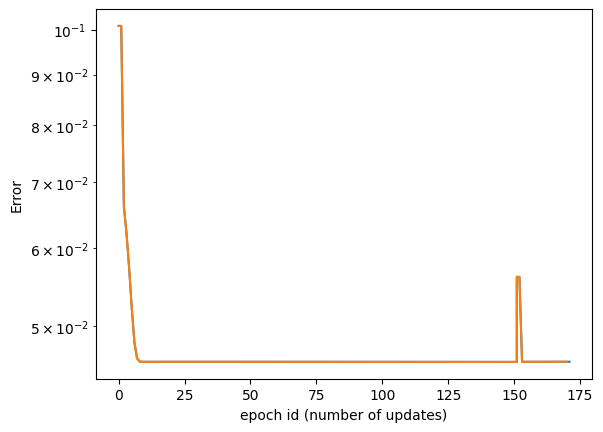

In [86]:
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_val,label='validation loss') 
#or use fit_sys_ss_enc.epoch_id for epochs

plt.xlabel('epoch id (number of updates)')
plt.ylabel('Error')

fit_sys.checkpoint_load_system('_best')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_val,label='validation loss stopped early')
plt.legend()
plt.show()


fit_sys.checkpoint_load_system('_last')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_train**0.5,label='train sqrt loss')
fit_sys.checkpoint_load_system('_best')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_train**0.5,label='train sqrt loss stopped early')
plt.xlabel('epoch id (number of updates)')
plt.ylabel('Error')
plt.show()


In [87]:
def NRMS(x_true, x_pred):
    rms = np.sqrt(np.mean((x_true-x_pred)**2, axis=0))
    return rms, rms/np.std(x_true, axis=0)

In [88]:
arrow_sim_enc = fit_sys.apply_experiment(test_arrow_full)
print("arrow")
arrow_sim_enc_no_ext = fit_sys.apply_experiment(test_arrow_no_extrapolation)
print("next")
test_sim_enc = fit_sys.apply_experiment(test_multisine)
print("multi")

arrow
next
multi


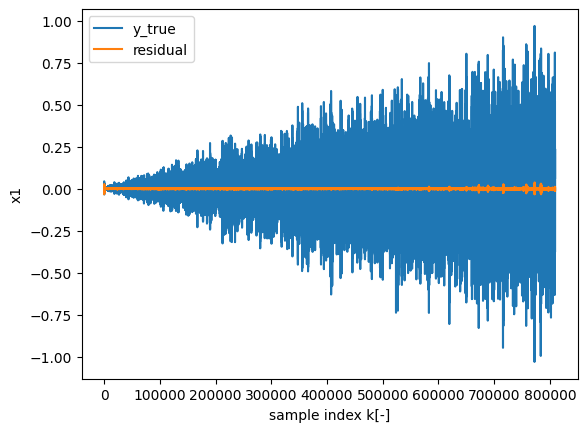

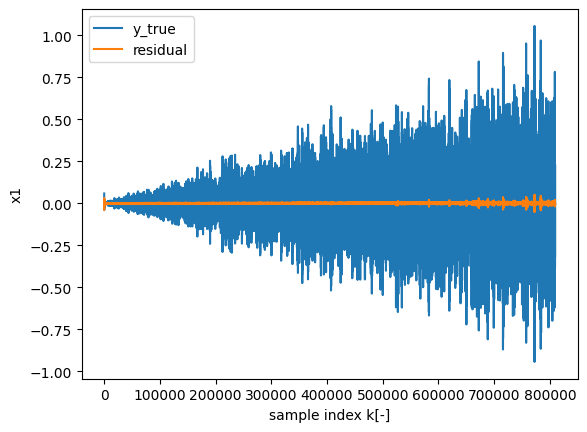

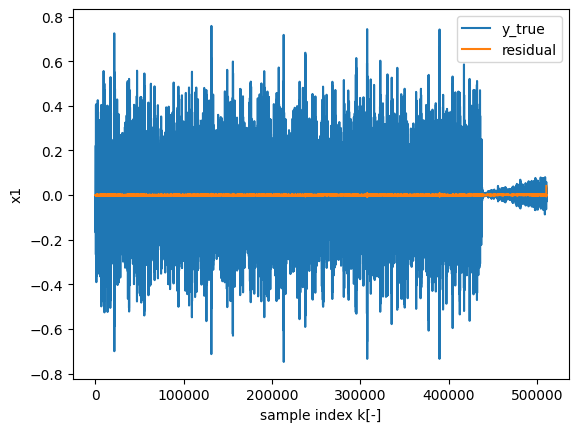

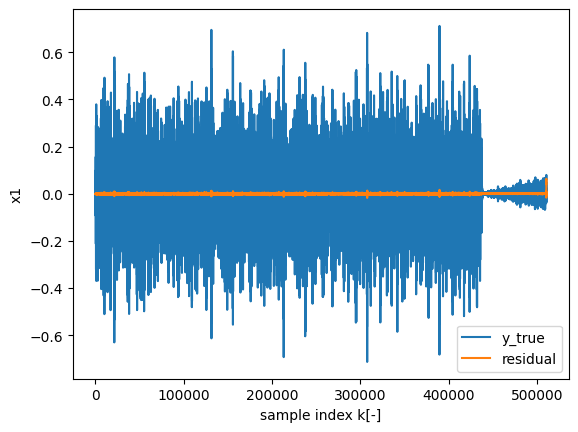

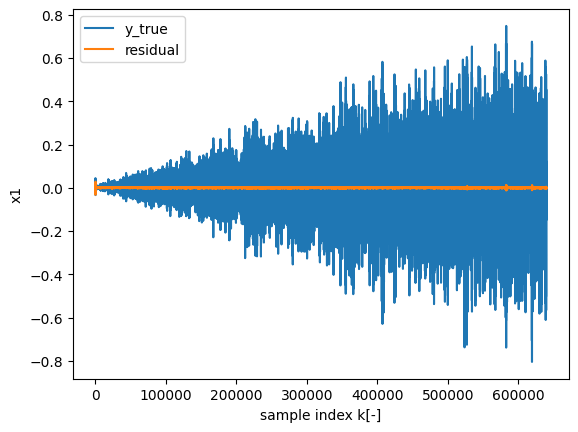

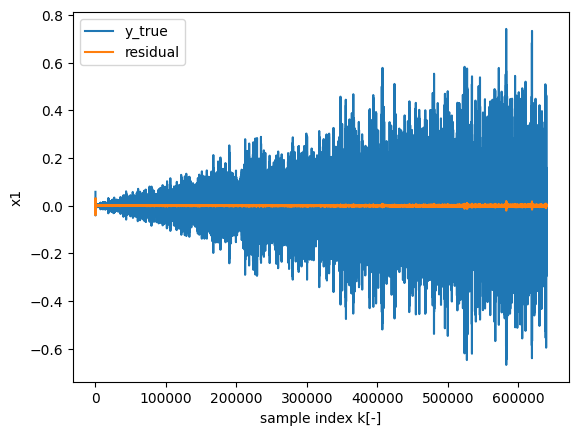

test sets NRMS/RMS 
 arrow full: (0.010827620530268763, 0.0018934397180723956)
 multisine: (0.00609703801858018, 0.0010030176249506224)
 arrow no ext: (0.008450515370552707, 0.0011842522658539593)


In [89]:
plt.plot(test_arrow_full.y[:,0])
plt.plot(test_arrow_full.y[:,0]-arrow_sim_enc.y[:,0])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
plt.plot(test_arrow_full.y[:,1])
plt.plot(test_arrow_full.y[:,1]-arrow_sim_enc.y[:,1])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
NRMS_af = arrow_sim_enc.NRMS(test_arrow_full)
RMS_af  = arrow_sim_enc.RMS(test_arrow_full)
x1_RMS_af, x1_NRMS_af = NRMS(test_arrow_full.y[:,0], arrow_sim_enc.y[:,0])

plt.plot(test_multisine.y[:,0])
plt.plot(test_multisine.y[:,0]-test_sim_enc.y[:,0])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
plt.plot(test_multisine.y[:,1])
plt.plot(test_multisine.y[:,1]-test_sim_enc.y[:,1])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
NRMS_tm = test_sim_enc.NRMS(test_multisine)
RMS_tm  = test_sim_enc.RMS(test_multisine)
x1_RMS_tm, x1_NRMS_tm = NRMS(test_multisine.y[:,0],test_sim_enc.y[:,0])

plt.plot(test_arrow_no_extrapolation.y[:,0])
plt.plot(test_arrow_no_extrapolation.y[:,0]-arrow_sim_enc_no_ext.y[:,0])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
plt.plot(test_arrow_no_extrapolation.y[:,1])
plt.plot(test_arrow_no_extrapolation.y[:,1]-arrow_sim_enc_no_ext.y[:,1])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
NRMS_ae = arrow_sim_enc_no_ext.NRMS(test_arrow_no_extrapolation)
RMS_ae  = arrow_sim_enc_no_ext.RMS(test_arrow_no_extrapolation)
x1_RMS_ae, x1_NRMS_ae = NRMS(test_arrow_no_extrapolation.y[:,0],arrow_sim_enc_no_ext.y[:,0])

print(f'test sets NRMS/RMS \n arrow full: ({x1_NRMS_af}, {x1_RMS_af})\n multisine: ({x1_NRMS_tm}, {x1_RMS_tm})\n arrow no ext: ({x1_NRMS_ae}, {x1_RMS_ae})')

In [90]:
from nonlinear_benchmarks.error_metrics import RMSE

n = 20*50

test_multisine_RMSE = 1000*RMSE(test_multisine.y[n:420000]-np.mean(test_multisine.y[n:420000]), test_sim_enc.y[n:420000]-np.mean(test_sim_enc.y[n:420000]))
test_arrow_full_RMSE = 1000*RMSE(test_arrow_full.y[n:]-np.mean(test_arrow_full.y[n:]), arrow_sim_enc.y[n:]-np.mean( arrow_sim_enc.y[n:]))
test_arrow_no_extrapolation_RMSE = 1000*RMSE(test_arrow_no_extrapolation.y[n:]-np.mean(test_arrow_no_extrapolation.y[n:]), arrow_sim_enc_no_ext.y[n:]-np.mean(arrow_sim_enc_no_ext.y[n:]))

# print(f'{test_multisine_RMSE[0]:.3f} mV')
# print(f'{test_arrow_full_RMSE[0]:.3f} mV')
# print(f'{test_arrow_no_extrapolation_RMSE[0]:.3f} mV')

In [91]:
print(f'RMSE to submit = [{1/T[0,0]**0.5 * test_multisine_RMSE[0]:.3f}; {1/T[0,0]**0.5 * test_arrow_full_RMSE[0]:.3f}; {1/T[0,0]**0.5 * test_arrow_no_extrapolation_RMSE[0]:.3f}]')

RMSE to submit = [0.550; 1.014; 0.586]


In [92]:
# [0.606; 0.930; 0.612] NO ENCODER AND H p3
# [0.876; 2.221; 0.769] NO ENCODER AND H p5

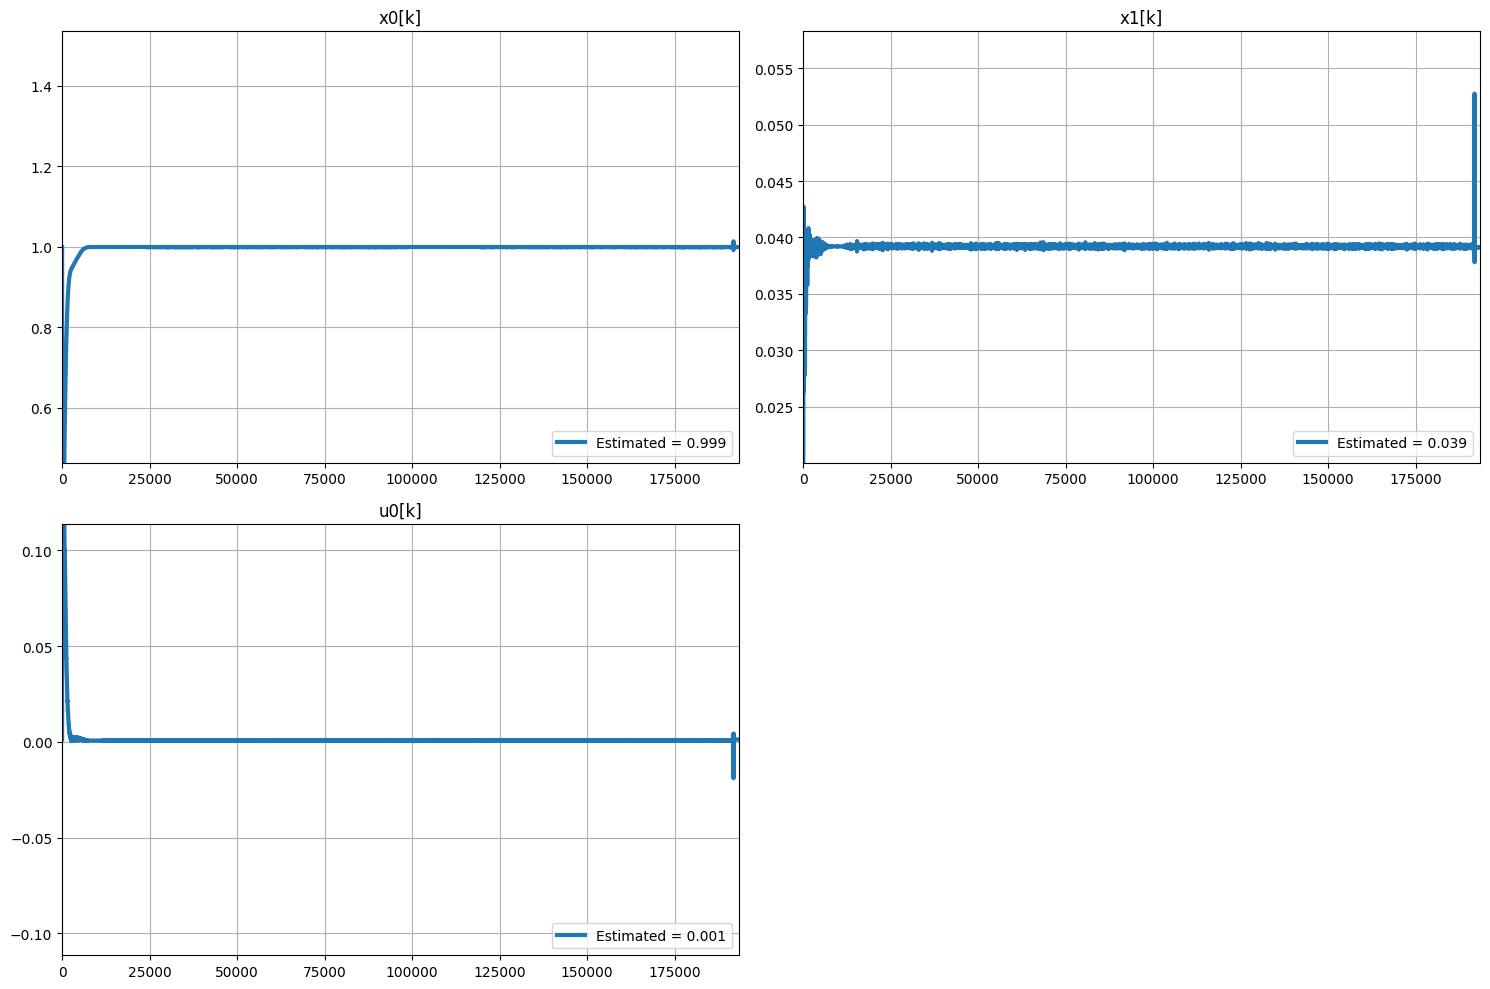

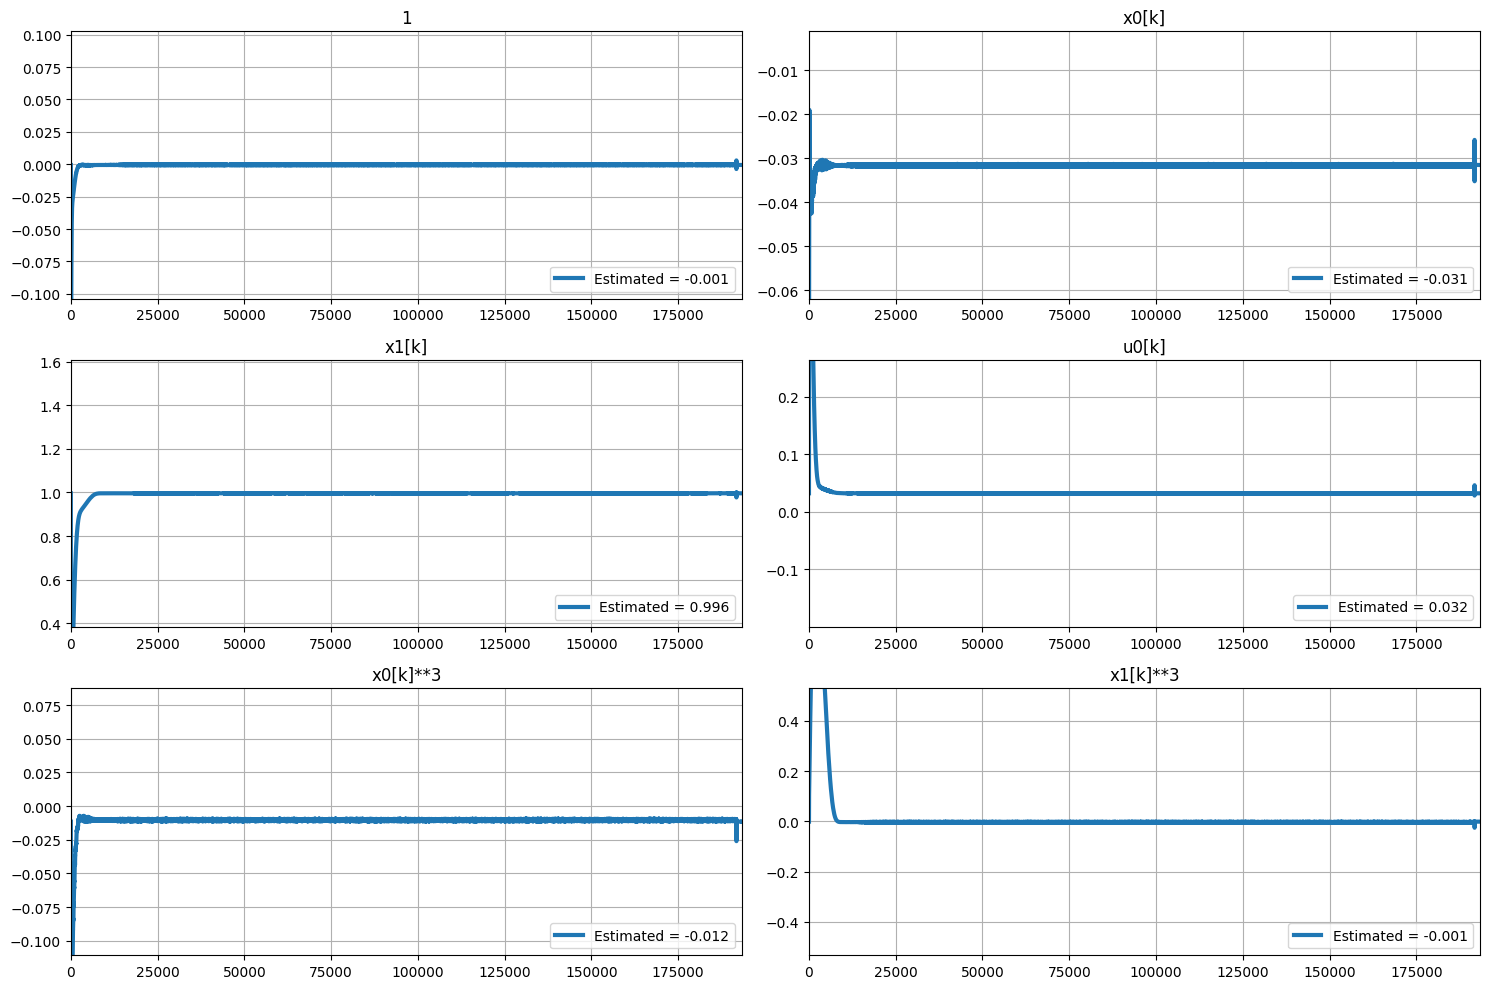

In [84]:
coeff = fit_sys.coefficients
coeff = np.array(coeff).T
plot_coeff_grid(coeff, states=2, labels=poly.feature_names, save=False, precision=3, threshold=0)